In [3]:
import pandas as pd
import numpy as np
import os
from sklearn import preprocessing
import seaborn as sns
from PIL import Image
from IPython.display import Image
from keras.models import Sequential
from keras.layers import Dense,LSTM,GRU,SimpleRNN,Activation
from sklearn.metrics import mean_squared_error
import livelossplot
from keras_sequential_ascii import keras2ascii
from sklearn.cross_validation import train_test_split
from keras import optimizers,metrics
import pickle
from pandas import concat
from keras import losses
from keras import backend
import matplotlib.pyplot as plt
from keras.callbacks import History 
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt



%matplotlib inline


C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


#Loading Data

In [4]:
path=r"I:\personal\Laptop G\G laptop folder\My Projects\Jupyter\PhD Implemntation\Final Pre-processed Data"
os.chdir(path)

In [5]:
print(os.getcwd())

I:\personal\Laptop G\G laptop folder\My Projects\Jupyter\PhD Implemntation\Final Pre-processed Data


In [ ]:
with open('filtered_data(L1in,L2out,L3out).pickle', 'rb') as handle1:
    b = pickle.load(handle1)

#sorting the data for LSTM
#converting the time series to a sequential supervised elarning problem

In [ ]:
def sequence_to_supervised(data,lag=1):
    #already in dataframe so no need to convert it
    df=pd.DataFrame(data)
    columns=[df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df= concat(columns,axis=1)
    df.fillna(0,inplace=True)
    return df

#Final Scaling the data to Min Max in range (0,1)
#Althoug the data is already normalised

In [ ]:

def MinMaxScaleFunc(data):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(data)
    return scaled

# LSTM 

#defining the model and training

In [ ]:
#decalring variable for callbacks to store trained metrics
history = History()

In [ ]:
# defing the learning rate and the keras plot library to visulise metrics
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.7, nesterov=False)
plot_losses = livelossplot.PlotLossesKeras()

#A common error meaaure to be considered for model with 
#different parameters

In [ ]:
def rmse(y_true, y_pred):
    
    #result.append(np.sqrt(np.mean(np.square(y_pred - y_true))))
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1)) 

In [ ]:
def lstm_fit(train, batch_size, nb_epoch, neurons):
    
    X,y=train[:,0:3],train_data[:,3:6]
    X=X.reshape(X.shape[0],1,X.shape[1])
    model=Sequential()
    model.add(LSTM(35,batch_input_shape=(batch_size,X.shape[1],X.shape[2]),activation='sigmoid',
                   return_sequences=True))
    model.add(LSTM(15,activation='sigmoid'))
    model.add(Dense(3))
    model.add(Activation('relu'))
    model.compile(loss=metrics.poisson,optimizer='RMSprop', 
                  metrics=['accuracy',rmse])
    #for i in range(nb_epoch):
    model.fit(X, y,epochs=nb_epoch, batch_size=1, verbose=0, shuffle=False,
              validation_split=0.2,callbacks=[livelossplot.PlotLossesKeras(),history])
    #model.reset_states()
    return model   

    

#fitting the model with changing cost functions

In [ ]:
supervised_data=sequence_to_supervised(b,1)
######fetching just the values or arrays
supervised_data_values=supervised_data.values
# manually splitting the data into train and test data as the sequence matters
train_data,test_data=supervised_data_values,supervised_data_values[:,0:3]
#transforming the data with the scaling function [0,1] ---- MinMax Normalisation
train_data=MinMaxScaleFunc(train_data)
#created validation sets
########################################
################ fiting the model##########
lstm_fitted_model=lstm_fit(train_data, batch_size=1,nb_epoch=20, neurons=10)

In [ ]:
#saving the trained model
lstm_fitted_model.save('dummy.h5')

In [ ]:
# predicitng for some test values from original dataset
test_data=supervised_data_values[:,0:3]
test_data=test_data.reshape(test_data.shape[0],1,test_data.shape[1])
lstm_fitted_model.predict(test_data,batch_size=1)[3251]


In [ ]:
test_data[3251]

In [ ]:
#getting model history values
a=history.history

#storing the results everytime into series->dataframe->excel

In [ ]:

# getting per epoch trained model history values
for i in history.history.keys():
    a[i]=np.mean(a[i],axis=0)




In [ ]:
#converting a list to series
z = pd.Series(a,name='Poisson')

In [ ]:
#series frame conversion after taking transpose
z= pd.DataFrame(z)

In [ ]:
#taking transpose
z=z.T

In [ ]:
#rearranging the results dataframe columnwise
z['Optimiser']=str('RMSprop')
z['Epochs']=20
z = z.reindex(columns=['loss','acc','rmse','val_rmse','val_loss','val_acc','Optimiser','Epochs'])


In [ ]:
z

In [ ]:
#reading the excel sheet to append results
x=pd.read_excel('Results_Objective_Function.xlsx')
x=x.append(z)


In [ ]:
# storing the results in an excel sheet to read
# and append again with changed model loss function
writer = pd.ExcelWriter('Results_Objective_Function.xlsx')

x.to_excel(writer,'Sheet1')
writer.save()

#Lodaing the Stored file to plot the individual results w.r.t the optimiser used

In [6]:
y=pd.read_excel('Results_Objective_Function.xlsx')

In [23]:
y

,Epochs,Optimiser,acc,loss,rmse,val_acc,val_loss,val_rmse
Mean Square Error,20,Adagrad,0.601250,0.103807,0.237074,0.617896,0.092994,0.221333
cosine_proximity,20,Adagrad,0.666282,-0.582410,0.528418,0.668203,-0.582629,0.528625
cosine,20,Adagrad,0.503153,-0.757847,0.530014,0.492320,-0.758672,0.531012
hinge,20,Adagrad,0.083429,1.000000,0.586202,0.082949,1.000000,0.586609
kullback_leibler_divergence,20,Adagrad,0.416955,8.252909,0.547067,0.414747,8.258453,0.546726
logcosh,20,Adagrad,0.250250,0.092281,0.432219,0.248848,0.091879,0.431357
Mean Absolute Error,20,Adagrad,0.550096,0.303923,0.405613,0.554685,0.302799,0.404928
Mean Squared Logarithmic Error,20,Adagrad,0.083429,0.174712,0.530878,0.082949,0.174523,0.530492
Poisson,20,Adagrad,0.245156,3.848531,0.428428,0.244700,3.850987,0.427446
Mean Square Error,20,Stochastic gradient descent,0.083429,0.333404,0.553405,0.082949,0.332767,0.553319


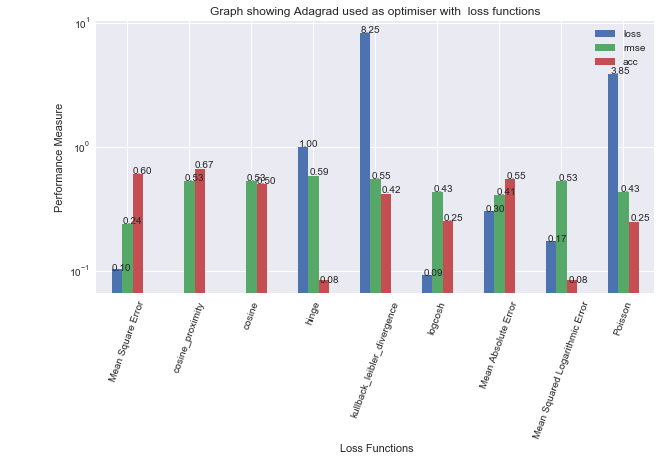

In [53]:
# plotting and saving the figure for Adagrad optimiser
ax=y[y.Optimiser=='Adagrad'].plot(kind='bar',y=['loss','rmse','acc'],figsize=(10,5),subplots=False,grid=True,legend=True,
                              title='Graph showing Adagrad used as optimiser with different loss functions',logy=True)
for p in ax.patches:
    valy = "{0:.2f}".format(round(p.get_height(),2))
    valx = "{0:.2f}".format(round(p.get_x(),2))
    
    ax.annotate(str(valy), (float(valx)*1.005 , float(valy) *1.005))
plt.xticks(rotation=70)
plt.xlabel(' Loss Functions')
plt.ylabel('Performance Measure')
plt.title('Graph showing Adagrad used as optimiser with  loss functions')
plt.savefig('output_pm_adagrad.png')

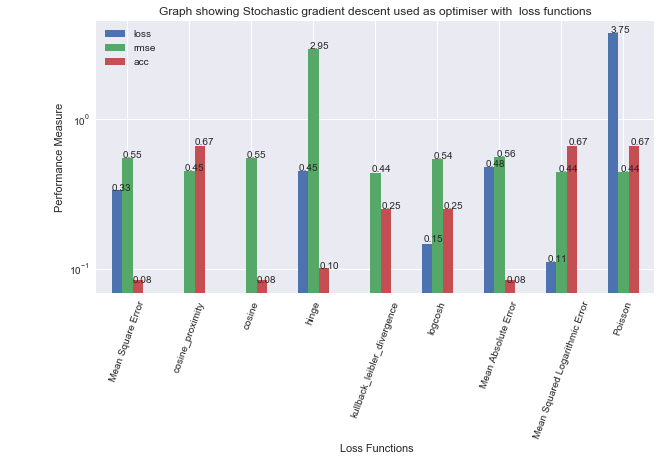

In [54]:
# plotting and saving the figure for Adagrad optimiser
ax=y[y.Optimiser=='Stochastic gradient descent'].plot(kind='bar',y=['loss','rmse','acc'],figsize=(10,5),subplots=False,grid=True,legend=True,
                              title='Graph showing Adagrad used as optimiser with different loss functions',logy=True)
for p in ax.patches:
    valy = "{0:.2f}".format(round(p.get_height(),2))
    valx = "{0:.2f}".format(round(p.get_x(),2))
    
    ax.annotate(str(valy), (float(valx)*1.005 , float(valy) *1.005))
plt.xticks(rotation=70)
plt.xlabel(' Loss Functions')
plt.ylabel('Performance Measure')
plt.title('Graph showing Stochastic gradient descent used as optimiser with  loss functions')
plt.savefig('output_pm_sgd.png')

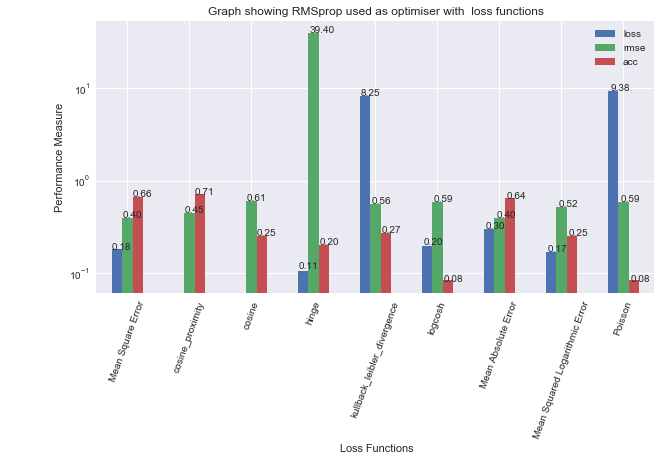

In [55]:
# plotting and saving the figure for Adagrad optimiser
ax=y[y.Optimiser=='RMSprop'].plot(kind='bar',y=['loss','rmse','acc'],figsize=(10,5),subplots=False,grid=True,legend=True,
                              title='Graph showing Adagrad used as optimiser with different loss functions',logy=True)
for p in ax.patches:
    valy = "{0:.2f}".format(round(p.get_height(),2))
    valx = "{0:.2f}".format(round(p.get_x(),2))
    
    ax.annotate(str(valy), (float(valx)*1.005 , float(valy) *1.005))
plt.xticks(rotation=70)
plt.xlabel(' Loss Functions')
plt.ylabel('Performance Measure')
plt.title('Graph showing RMSprop used as optimiser with  loss functions')
plt.savefig('output_pm_RMSprop.png')